<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/Bias_Evaluation_Inference_FER_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. get dataset / dataloader
3. get output
2. load model
4. get task accuracy
4. get demographic parity
5. get equality odds



## Cloning Repo, Installing dependencies

In [ ]:
# !pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 541 (delta 27), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (541/541), 45.66 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (301/301), done.


In [2]:

!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP

from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE
from da_cv_fer.utils import *
from da_cv_fer.run_config import RunConfig




In [3]:
# install general libraries
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd


## Initializing Configs

In [ ]:

#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## Loading csv files (evaluation results)

In [4]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


In [ ]:
# non_dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_08_04.csv')
# dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_08_04.csv')
# ewc_dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_08_04.csv')

In [5]:
# base_dir = ""
non_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_08_04.csv')
dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_08_04.csv')
ewc_dann_result=pd.read_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_08_04.csv')

In [6]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,angry_man_391.jpg,Angry,White,Sad
1,1,distaste_face_874.jpg,Neutral,White,Sad
2,2,surprised_expression_680.jpg,Neutral,White,Sad
3,3,awe_student_733.jpg,Happy,Indian,Sad
4,4,excited_man_281.jpg,Happy,White,Sad
...,...,...,...,...,...
8453,8453,angry_couple_433.jpg,Angry,Indian,Sad
8454,8454,fighting_husband_91.jpg,Angry,White,Sad
8455,8455,heartbroken_man_83.jpg,Sad,Latino,Sad
8456,8456,annoyed_student_226.jpg,Angry,White,Sad


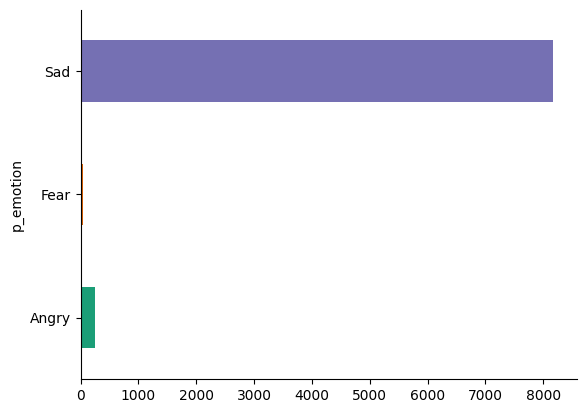

In [9]:
# @title p_emotion

from matplotlib import pyplot as plt
import seaborn as sns
non_dann_result.groupby('p_emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,fierce_son_457.jpg,Neutral,White,Sad
1,1,amazed_African_192.jpg,Neutral,White,Sad
2,2,amazed_student_595.jpg,Happy,White,Sad
3,3,boring_actor_875.jpg,Angry,White,Sad
4,4,fighting_mother_441.jpg,Neutral,White,Sad
...,...,...,...,...,...
8453,8453,angry_president_17.jpg,Neutral,African,Sad
8454,8454,fierce_european_210.jpg,Happy,White,Sad
8455,8455,awe_couple_215.jpg,Happy,Asian,Sad
8456,8456,fierce_father_831.jpg,Surprise,African,Sad


In [8]:
ewc_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,awe_chinese_584.jpg,Happy,Asian,Sad
1,1,annoyed_people_456.jpg,Neutral,White,Sad
2,2,astound_soldier_922.jpg,Neutral,White,Sad
3,3,hostile_family_153.jpg,Happy,White,Sad
4,4,distressed_soldier_654.jpg,Sad,Middle Eastern,Sad
...,...,...,...,...,...
8453,8453,fierce_student_170.jpg,Happy,White,Sad
8454,8454,angry_american_541.jpg,Happy,White,Sad
8455,8455,mad_expression_666.jpg,Angry,Middle Eastern,Angry
8456,8456,awe_lady_218.jpg,Neutral,White,Sad


### Demographic Parity

In [9]:
df = non_dann_result

In [31]:
df

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,angry_man_391.jpg,Angry,White,Sad
1,1,distaste_face_874.jpg,Neutral,White,Sad
2,2,surprised_expression_680.jpg,Neutral,White,Sad
3,3,awe_student_733.jpg,Happy,Indian,Sad
4,4,excited_man_281.jpg,Happy,White,Sad
...,...,...,...,...,...
8453,8453,angry_couple_433.jpg,Angry,Indian,Sad
8454,8454,fighting_husband_91.jpg,Angry,White,Sad
8455,8455,heartbroken_man_83.jpg,Sad,Latino,Sad
8456,8456,annoyed_student_226.jpg,Angry,White,Sad


In [10]:
pivot_race_gt_emotion = pd.pivot_table(df, index='gt_race', columns='gt_emotion', aggfunc='size', fill_value=0)
pivot_race_gt_emotion

gt_emotion,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
gt_race,,,,,,,
African,27,42,7,243,367,93,35
Asian,37,52,9,346,407,158,63
Indian,21,22,3,157,285,64,28
Latino,3,0,0,115,13,38,25
Middle Eastern,7,8,1,51,80,38,17
White,249,258,74,1879,2026,625,485


In [11]:
pivot_race_p_emotion = pd.pivot_table(df, index='gt_race', columns='p_emotion', aggfunc='size', fill_value=0)
pivot_race_p_emotion

p_emotion,Angry,Fear,Sad
gt_race,,,
African,20,2,792
Asian,21,1,1050
Indian,9,2,569
Latino,5,1,188
Middle Eastern,7,0,195
White,191,31,5374


In [12]:
df_race_gt_emotion = pivot_race_gt_emotion.reset_index()
df_race_gt_emotion

gt_emotion,gt_race,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
0,African,27,42,7,243,367,93,35
1,Asian,37,52,9,346,407,158,63
2,Indian,21,22,3,157,285,64,28
3,Latino,3,0,0,115,13,38,25
4,Middle Eastern,7,8,1,51,80,38,17
5,White,249,258,74,1879,2026,625,485


In [13]:
df_race_gt_emotion.columns

Index(['gt_race', 'Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad',
       'Surprise'],
      dtype='object', name='gt_emotion')

In [14]:
df_race_gt_emotion.columns[1:]

Index(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'], dtype='object', name='gt_emotion')

In [15]:
def get_race_emotion_distribution (df:pd.DataFrame) -> dict:
  race_emotion_distribution = {} # {race:{emotion:count}}

  for index, row in df.iterrows():
    emotion_distribution ={} # {emotion:count}
    # for emotion in df.columns[1:]:
    for emotion in ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] :
      try:
        emotion_distribution[emotion] = row[emotion]
      except:
        emotion_distribution[emotion] = 0

    race_emotion_distribution[row[df.columns[0]]] = emotion_distribution

  return race_emotion_distribution


In [16]:
ground_truth_race_emotion_distribution = get_race_emotion_distribution(df_race_gt_emotion)
ground_truth_race_emotion_distribution

{'African': {'Angry': 27,
  'Disgust': 42,
  'Fear': 7,
  'Happy': 243,
  'Neutral': 367,
  'Sad': 93,
  'Surprise': 35},
 'Asian': {'Angry': 37,
  'Disgust': 52,
  'Fear': 9,
  'Happy': 346,
  'Neutral': 407,
  'Sad': 158,
  'Surprise': 63},
 'Indian': {'Angry': 21,
  'Disgust': 22,
  'Fear': 3,
  'Happy': 157,
  'Neutral': 285,
  'Sad': 64,
  'Surprise': 28},
 'Latino': {'Angry': 3,
  'Disgust': 0,
  'Fear': 0,
  'Happy': 115,
  'Neutral': 13,
  'Sad': 38,
  'Surprise': 25},
 'Middle Eastern': {'Angry': 7,
  'Disgust': 8,
  'Fear': 1,
  'Happy': 51,
  'Neutral': 80,
  'Sad': 38,
  'Surprise': 17},
 'White': {'Angry': 249,
  'Disgust': 258,
  'Fear': 74,
  'Happy': 1879,
  'Neutral': 2026,
  'Sad': 625,
  'Surprise': 485}}

In [17]:
ground_truth_race_emotion_distribution.keys()

dict_keys(['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'])

In [18]:
predicted_race_emotion_distribution = get_race_emotion_distribution(pivot_race_p_emotion.reset_index() )
predicted_race_emotion_distribution

{'African': {'Angry': 20,
  'Disgust': 0,
  'Fear': 2,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 792,
  'Surprise': 0},
 'Asian': {'Angry': 21,
  'Disgust': 0,
  'Fear': 1,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 1050,
  'Surprise': 0},
 'Indian': {'Angry': 9,
  'Disgust': 0,
  'Fear': 2,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 569,
  'Surprise': 0},
 'Latino': {'Angry': 5,
  'Disgust': 0,
  'Fear': 1,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 188,
  'Surprise': 0},
 'Middle Eastern': {'Angry': 7,
  'Disgust': 0,
  'Fear': 0,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 195,
  'Surprise': 0},
 'White': {'Angry': 191,
  'Disgust': 0,
  'Fear': 31,
  'Happy': 0,
  'Neutral': 0,
  'Sad': 5374,
  'Surprise': 0}}

In [19]:
np.array(list(predicted_race_emotion_distribution['Asian'].values()))

array([  21,    0,    1,    0,    0, 1050,    0])

In [20]:
# Function to perform Chi-Square test for each demographic group
import numpy as np
from scipy.stats import chi2
def chi_square_test(expected_counts, predicted_counts,
                    demographic_groups = ['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'],
                    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'], alpha=0.05):
    results = {}

    for group in demographic_groups:
        expected = np.array(list(expected_counts[group].values()))
        predicted = np.array(list(predicted_counts[group].values()))

        # Calculate the Chi-Square statistic
        chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)

        # Degrees of freedom
        degrees_of_freedom = len(emotions) - 1

        # Critical value for the significance level
        critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

        # P-Value
        p_value = chi2.sf(chi_square_statistic, degrees_of_freedom)

        # Store the results
        results[group] = {
            'Chi-Square Statistic': chi_square_statistic,
            'Critical Value': critical_value,
            'P-Value': p_value,
            'Significant': chi_square_statistic > critical_value
        }

    return results


In [21]:
# chi_square_test(expected_counts, predicted_counts, demographic_groups, emotions, alpha=0.05)
results = chi_square_test(ground_truth_race_emotion_distribution, predicted_race_emotion_distribution )

<ipython-input-20-df8a33d6e450>:14: RuntimeWarning: divide by zero encountered in divide
  chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)
<ipython-input-20-df8a33d6e450>:14: RuntimeWarning: invalid value encountered in divide
  chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)


In [22]:
# Print the results
for group, result in results.items():
    print(f"Demographic Group: {group}")
    print(f"  Chi-Square Statistic: {result['Chi-Square Statistic']:.4f}")
    print(f"  Critical Value (0.05 significance level): {result['Critical Value']:.4f}")
    print(f"  P-Value: {result['P-Value']:.4f}")
    if result['Significant']:
        print("  Result: Significant difference between predicted and expected distributions.")
    else:
        print("  Result: No significant difference between predicted and expected distributions.")
    print()

Demographic Group: African
  Chi-Square Statistic: 5946.1604
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Asian
  Chi-Square Statistic: 5917.8781
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Indian
  Chi-Square Statistic: 4483.9561
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Latino
  Chi-Square Statistic: nan
  Critical Value (0.05 significance level): 12.5916
  P-Value: nan
  Result: No significant difference between predicted and expected distributions.

Demographic Group: Middle Eastern
  Chi-Square Statistic: 805.6579
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant differe

### Disparate Impact

In [46]:
#@title Function to calculate accuracy for each race
def calculate_accuracy_per_race(df):
    accuracies = {}
    for race, group in df.groupby('gt_race'):
      # print (race)
      correct_predictions = (group['gt_emotion'] == group['p_emotion']).sum()

      total_predictions = group.shape[0]
      accuracy = correct_predictions / total_predictions
      # print(f' correct_predictions:{correct_predictions}, total_predictions: {total_predictions}, accuracy : {accuracy}')
      accuracies[race] = accuracy
    return accuracies
  # print(group['Angry'])


In [47]:
accuracies_per_race_non_dann  = calculate_accuracy_per_race(non_dann_result)
accuracies_per_race_non_dann

{'African': 0.12162162162162163,
 'Asian': 0.15578358208955223,
 'Indian': 0.11379310344827587,
 'Latino': 0.1958762886597938,
 'Middle Eastern': 0.19306930693069307,
 'White': 0.12080057183702644}

In [77]:
max_accuracy_non_dann = max(accuracies_per_race_non_dann.values())
disparate_impact_ratios_non_dann = {race: (accuracy) / max_accuracy_non_dann for race, accuracy in accuracies_per_race_non_dann.items()}
disparate_impact_ratios_non_dann

{'African': 0.6209103840682788,
 'Asian': 0.7953161822466613,
 'Indian': 0.5809437386569873,
 'Latino': 1.0,
 'Middle Eastern': 0.9856696195935384,
 'White': 0.6167187088521876}

In [78]:
accuracies_per_race_dann  = calculate_accuracy_per_race(dann_result)
print(accuracies_per_race_dann)
max_accuracy_dann = max(accuracies_per_race_dann.values())
print(max_accuracy_dann)
disparate_impact_ratios_dann = {race: (accuracy) / max_accuracy_dann for race, accuracy in accuracies_per_race_dann.items()}
print(disparate_impact_ratios_dann)

{'African': 0.12162162162162163, 'Asian': 0.15578358208955223, 'Indian': 0.11379310344827587, 'Latino': 0.1958762886597938, 'Middle Eastern': 0.19306930693069307, 'White': 0.12080057183702644}
0.1958762886597938
{'African': 0.6209103840682788, 'Asian': 0.7953161822466613, 'Indian': 0.5809437386569873, 'Latino': 1.0, 'Middle Eastern': 0.9856696195935384, 'White': 0.6167187088521876}


In [79]:
accuracies_per_race_ewc_dann  = calculate_accuracy_per_race(ewc_dann_result)
print(accuracies_per_race_ewc_dann)
max_accuracy_ewc_dann = max(accuracies_per_race_ewc_dann.values())
print(max_accuracy_ewc_dann)
disparate_impact_ratios_ewc_dann = {race: (accuracy) / max_accuracy_ewc_dann for race, accuracy in accuracies_per_race_ewc_dann.items()}
print(disparate_impact_ratios_ewc_dann)

{'African': 0.12162162162162163, 'Asian': 0.15578358208955223, 'Indian': 0.11379310344827587, 'Latino': 0.1958762886597938, 'Middle Eastern': 0.19306930693069307, 'White': 0.12080057183702644}
0.1958762886597938
{'African': 0.6209103840682788, 'Asian': 0.7953161822466613, 'Indian': 0.5809437386569873, 'Latino': 1.0, 'Middle Eastern': 0.9856696195935384, 'White': 0.6167187088521876}


In [80]:
dicts = [disparate_impact_ratios_non_dann, disparate_impact_ratios_dann, disparate_impact_ratios_ewc_dann]
labels = ['non_dann', 'dann', 'dann_ewc']
df_disparate_impact = pd.DataFrame(dicts, index=labels)
df_disparate_impact

,African,Asian,Indian,Latino,Middle Eastern,White
non_dann,0.62091,0.795316,0.580944,1.0,0.98567,0.616719
dann,0.62091,0.795316,0.580944,1.0,0.98567,0.616719
dann_ewc,0.62091,0.795316,0.580944,1.0,0.98567,0.616719


### Equalized Odds

In [111]:
from sklearn.metrics import confusion_matrix

def calculate_tpr_fpr_per_race(df):

    # float_formatter = ":.2f".format
    # np.set_printoptions() #(formatter={'float_kind':})
    race_groups = df.groupby('gt_race')
    tpr_fpr = {}
    for race, group in race_groups:
        cm = confusion_matrix(group['gt_emotion'], group['p_emotion'], labels=emotions)
        # print(race)
        # print(cm)
        tp = cm.diagonal()
        # print(f'tp : {tp}')
        fn = cm.sum(axis=1) - tp
        # print(f'fn : {fn}')
        fp = cm.sum(axis=0) - tp
        tn = cm.sum() - (tp + fn + fp)

        tpr = tp / (tp + fn)
        tpr = np.nan_to_num(tpr)

        fpr = fp / (fp + tn)
        fpr = np.nan_to_num(fpr)

        tpr_diff_fpr = tpr - fpr
        tpr_diff_fpr = np.abs(tpr_diff_fpr)



        # print(f'Positive Rate = {tpr} for race: {race}')
        # print(f'tpr : {tpr}')

        # print(f'fpr : {fpr}')
        # fpr = fp / (fp + tn)
        tpr_fpr[race] = {'TPR': np.round(tpr,2), 'FPR': np.round(fpr,2), "TRP-FPR": np.round(tpr_diff_fpr,2)}
    return tpr_fpr

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# tpr_fpr_per_race = calculate_tpr_fpr_per_race(non_dann_result)
# tpr_fpr_per_race


In [112]:
tpr_fpr_per_race_non_dann = calculate_tpr_fpr_per_race(non_dann_result)
tpr_fpr_per_race_dann = calculate_tpr_fpr_per_race(dann_result)
tpr_fpr_per_race_ewc_dann = calculate_tpr_fpr_per_race(ewc_dann_result)

<ipython-input-111-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-111-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-111-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)


In [114]:
tpr_fpr_per_race_ewc_dann

{'African': {'TPR': array([0.37, 0.  , 0.  , 0.  , 0.96, 0.  , 0.  ]),
  'FPR': array([0.01, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ]),
  'TRP-FPR': array([0.36, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ])},
 'Asian': {'TPR': array([0.32, 0.  , 0.11, 0.  , 0.97, 0.  , 0.  ]),
  'FPR': array([0.01, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ]),
  'TRP-FPR': array([0.32, 0.  , 0.11, 0.  , 0.01, 0.  , 0.  ])},
 'Indian': {'TPR': array([0.14, 0.  , 0.33, 0.  , 0.97, 0.  , 0.  ]),
  'FPR': array([0.01, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ]),
  'TRP-FPR': array([0.13, 0.  , 0.33, 0.  , 0.01, 0.  , 0.  ])},
 'Latino': {'TPR': array([0.33, 0.  , 0.  , 0.  , 0.97, 0.  , 0.  ]),
  'FPR': array([0.02, 0.  , 0.01, 0.  , 0.97, 0.  , 0.  ]),
  'TRP-FPR': array([0.31, 0.  , 0.01, 0.  , 0.01, 0.  , 0.  ])},
 'Middle Eastern': {'TPR': array([0.43, 0.  , 0.  , 0.  , 0.95, 0.  , 0.  ]),
  'FPR': array([0.02, 0.  , 0.  , 0.  , 0.97, 0.  , 0.  ]),
  'TRP-FPR': array([0.41, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ])},
 'White': {'TPR':

In [82]:
for race, metrics in tpr_fpr_per_race.items():
    # print(f"Race: {race}, TPR: {metrics['TPR']}, FPR: {metrics['FPR']}")
    print(f"Race: {race}, Difference: {metrics['TPR'] - metrics['FPR']}")


Race: African, Difference: [ 0.35766389  0.         -0.00247831  0.         -0.01804543  0.
  0.        ]
Race: Asian, Difference: [ 0.31562867  0.          0.11111111  0.         -0.0056228   0.
  0.        ]
Race: Indian, Difference: [ 0.13212369  0.          0.33160023  0.         -0.01380814  0.
  0.        ]
Race: Latino, Difference: [0.31239092        nan        nan 0.         0.00573549 0.
 0.        ]
Race: Middle Eastern, Difference: [ 0.40805861  0.          0.          0.         -0.02214377  0.
  0.        ]
Race: White, Difference: [ 0.27951041  0.          0.03546991  0.         -0.00397248  0.
  0.        ]


In [ ]:
tpr_fpr_per_race_non_dann = calculate_tpr_fpr_per_race(non_dann_result)
tpr_fpr_per_race_dann = calculate_tpr_fpr_per_race(dann_result)
tpr_fpr_per_race_ewc_dann = calculate_tpr_fpr_per_race(ewc_dann_result)



##  Dataset
- EXPW Crop Race Loader

In [ ]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


In [ ]:
# EXPWIMAGECROPRACE

expw_obj = EXPWIMAGECROPRACE(type='val',crop_at_runtime=False)

expw_val_ds = expw_obj.get_dataset()
expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_val_loader.dataset)} , {len(expw_val_ds)}')

---NOT CROPPING AT RUNTIME --
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
self.list_img_label:  [('amazed_american_212.jpg', 0), ('angry_black_177.jpg', 0), ('angry_black_3.jpg', 0), ('angry_black_531.jpg', 0), ('angry_black_64.jpg', 0)]
expw_raceds_dict_list: [('amazed_american_212.jpg', 'African', 0), ('angry_black_177.jpg', 'African', 0), ('angry_black_3.jpg', 'African', 0), ('angry_black_531.jpg', 'African', 0), ('angry_black_64.jpg', 'African', 0)]
expw_raceds_dict_list_selected: 8458, [('amazed_american_212.jpg', 'African', 0), ('angry_black_177.jpg', 'African', 0), ('angry_black_3.jpg', 'African', 0), ('angry_black_531.jpg', 'African', 0), ('angry_black_64.jpg', 'African', 0)]
size of dataset (list_img_label): 8458
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/e

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


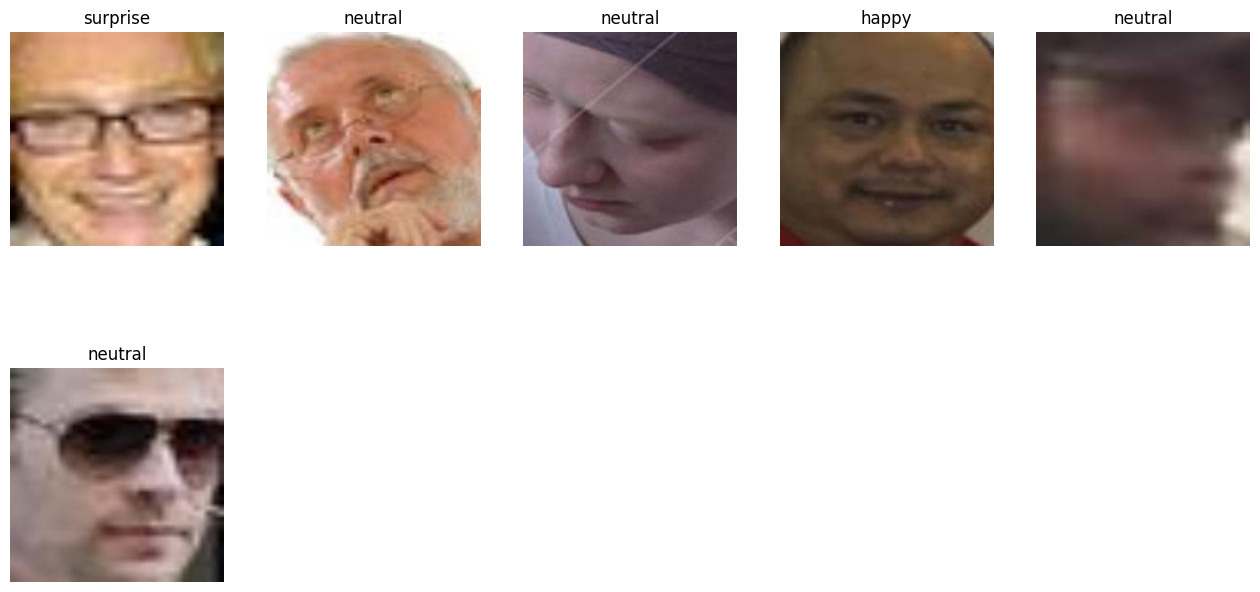

In [ ]:
show_batch(expw_val_loader,expw_val_ds.labels,6,normalized=False)

## Load Models

### Name of the *models*

In [ ]:
non_dann_model_sfew_expw_name = 'non_dann_sfew_expw_08_04.pt'
dann_model_sfew_expw_name ='dann_sfew_expw_08_04.pt'
ewc_dann_model_sfew_expw_name = 'ewc_dann_sfew_expw_08_04.pt'

## Model initialization and structure

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [ ]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features

### Loading **Models**

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
dataconfig_inference=DataConfig()

# MODEL_DIR = dataconfig_inference.MODEL_DIR

# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR
# DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR
# EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR

In [ ]:
# NON DANN
non_dann_model_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7) # skeleton copy
NON_DANN_SFEW_DIR =  Path(dataconfig_inference.MODEL_DIR,"non_dann_sfew_expw")

try:
    non_dann_model_inference.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_expw_name),
                                                        map_location=torch.device(device)))
    print(f'{non_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {non_dann_model_sfew_expw_name}')

# DANN
dann_model_sfew_expw_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7) # skeleton copy
DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"dann_sfew_expw")
try:
    dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(DANN_SFEW_EXPW_DIR, dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {dann_model_sfew_expw_name}')

# EWC DANN
ewc_dann_model_sfew_expw_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)#,backbone='resnet18', dropout=0.1) # skeleton copy
EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"ewc_dann_sfew_expw")
print(dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR)
try:
    ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(EWC_DANN_SFEW_EXPW_DIR, ewc_dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{ewc_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {ewc_dann_model_sfew_expw_name}')


non_dann_sfew_expw_08_04.pt locked and loaded
dann_sfew_expw_08_04.pt locked and loaded
/content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw
ewc_dann_sfew_expw_08_04.pt locked and loaded


In [ ]:
labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

In [ ]:

#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print(prediction.shape, labels.shape)
    # print(prediction)
    # print(prediction.argmax(dim=1))
    # print(labels)
    # print(labels.argmax(dim=1))
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

def test_model_race(model, device, test_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model(data)
            # print("class output",class_output.shape)
            # print("target ",target.shape)
            class_loss = class_loss_function(class_output, target)  # sum up batch loss
            test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].argmax(dim=-1).item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=-1)[i].item())]}
                # print(result_row)
                result.loc[len(result)] = result_row
                # result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

In [ ]:
# result_col = ['image','gt_emotion', 'gt_race', 'p_emotion']
# result = pd.DataFrame(columns=result_col)
# result

In [ ]:
len(expw_val_loader.dataset)

8458

In [ ]:
non_dann_correct, non_dann_test_loss, non_dann_accuracy, non_dann_result = test_model_race(model = non_dann_model_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test / Val: Average loss: 0.1288, Accuracy: 1085/8458 (12.83%)



In [ ]:
non_dann_result

,image,gt_emotion,gt_race,p_emotion
0,angry_man_391.jpg,Angry,White,Sad
1,distaste_face_874.jpg,Neutral,White,Sad
2,surprised_expression_680.jpg,Neutral,White,Sad
3,awe_student_733.jpg,Happy,Indian,Sad
4,excited_man_281.jpg,Happy,White,Sad
...,...,...,...,...
8453,angry_couple_433.jpg,Angry,Indian,Sad
8454,fighting_husband_91.jpg,Angry,White,Sad
8455,heartbroken_man_83.jpg,Sad,Latino,Sad
8456,annoyed_student_226.jpg,Angry,White,Sad


In [ ]:
# Create the pivot table
pivot_table = pd.pivot_table(non_dann_result, index='gt_emotion', columns='gt_race', aggfunc='size', fill_value=0)
print("\nPivot Table:")
print(pivot_table)


Pivot Table:
gt_race     African  Asian  Indian  Latino  Middle Eastern  White
gt_emotion                                                       
Angry            27     37      21       3               7    249
Disgust          42     52      22       0               8    258
Fear              7      9       3       0               1     74
Happy           243    346     157     115              51   1879
Neutral         367    407     285      13              80   2026
Sad              93    158      64      38              38    625
Surprise         35     63      28      25              17    485


In [ ]:
## Performance matrix can be calculated

In [ ]:
dann_correct, dann_test_loss, dann_accuracy, dann_result = test_model_race(model = dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test / Val: Average loss: 0.1288, Accuracy: 1085/8458 (12.83%)



In [ ]:
dann_result

,image,gt_emotion,gt_race,p_emotion
0,fierce_son_457.jpg,Neutral,White,Sad
1,amazed_African_192.jpg,Neutral,White,Sad
2,amazed_student_595.jpg,Happy,White,Sad
3,boring_actor_875.jpg,Angry,White,Sad
4,fighting_mother_441.jpg,Neutral,White,Sad
...,...,...,...,...
8453,angry_president_17.jpg,Neutral,African,Sad
8454,fierce_european_210.jpg,Happy,White,Sad
8455,awe_couple_215.jpg,Happy,Asian,Sad
8456,fierce_father_831.jpg,Surprise,African,Sad


In [ ]:
ewc_dann_correct, ewc_dann_test_loss, ewc_dann_accuracy, ewc_dann_result = test_model_race(model = ewc_dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test / Val: Average loss: 0.1288, Accuracy: 1085/8458 (12.83%)



In [ ]:
ewc_dann_result

,image,gt_emotion,gt_race,p_emotion
0,awe_chinese_584.jpg,Happy,Asian,Sad
1,annoyed_people_456.jpg,Neutral,White,Sad
2,astound_soldier_922.jpg,Neutral,White,Sad
3,hostile_family_153.jpg,Happy,White,Sad
4,distressed_soldier_654.jpg,Sad,Middle Eastern,Sad
...,...,...,...,...
8453,fierce_student_170.jpg,Happy,White,Sad
8454,angry_american_541.jpg,Happy,White,Sad
8455,mad_expression_666.jpg,Angry,Middle Eastern,Angry
8456,awe_lady_218.jpg,Neutral,White,Sad


### Saving the output

In [ ]:
non_dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_08_04.csv')
dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_08_04.csv')
ewc_dann_result.to_csv('/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_08_04.csv')